## 1 Introduction

I will be using the Northwind Traders Access database to perform a hypothesis test to answer the following question.  **_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**<br> 
Followed by at least 3 additional hypothesis tests.  <br>

**Synopsis of Dataset**<br>
"The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products, including SQL Server and Microsoft Access. The database contains the sales data for Northwind Traders, a fictitious specialty foods export/import company." 
<br>

**Null Hypothesis** <br>
The number of products customers order is not related to the level of discount <br>

**Alternative Hypothesis** <br>
The number of products customers order is related to the level of discount.<br>

**Effect Size**<br>
Numbers of products ordered at the 5%,15%,20%,25% levels of discount. 

**Variables We Are Interested in Determining the Relationship Between**<br>
Number of products ordered and percent discount<br>

### 1.1 Loading Libraries

In [1]:
# add every library I will use throughout the project here
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stat
from scipy import stats
from __future__ import print_function


#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#pivot tables for table joining
from pivottablejs import pivot_ui

#for t-tests
from scipy.stats import ttest_ind

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

### 1.2 Retrieve data from database

In [2]:
# create a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()

# query the database
c.execute("SELECT * FROM OrderDetail;")

# store results in a dataframe
df_orders = pd.DataFrame(c.fetchall())
df_orders.columns = [i[0] for i in c.description]

# double check everything imported correctly
df_orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


By looking at the provided schema I was able to locate the table of interest and save the relevant data within a Pandas dataframe for further analysis.  The **orders** table contains information with the variables of interest: **Discount** and **Quantity**. 

In [3]:
#Initial EDA using pivot_ui
pivot_ui(df_orders)

### 1.3 Data structure and content

In [4]:
df_orders.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

No null values that need to be cleaned.

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In total, there are 6 variables and 2155 entries.

In [6]:
df_orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


**OrderID** is simply an index so the values are insignificant as long as there are no duplicates.  **ProductId** contains 1 value for each order.  Therefore, I am making the assumption that each order contains only 1 type of product.  **UnitPrice** ranges from 2 to 263.50 I may take this number multiply it by the quantity and apply the discount to create a column for total sale for another hypothesis test.  **Quantity** is one of the features we are directly interested in, the values are all whole number integers between 1 and 130.  **Discount** is the other variable we are directly interested in and the range is 0-%25.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity')

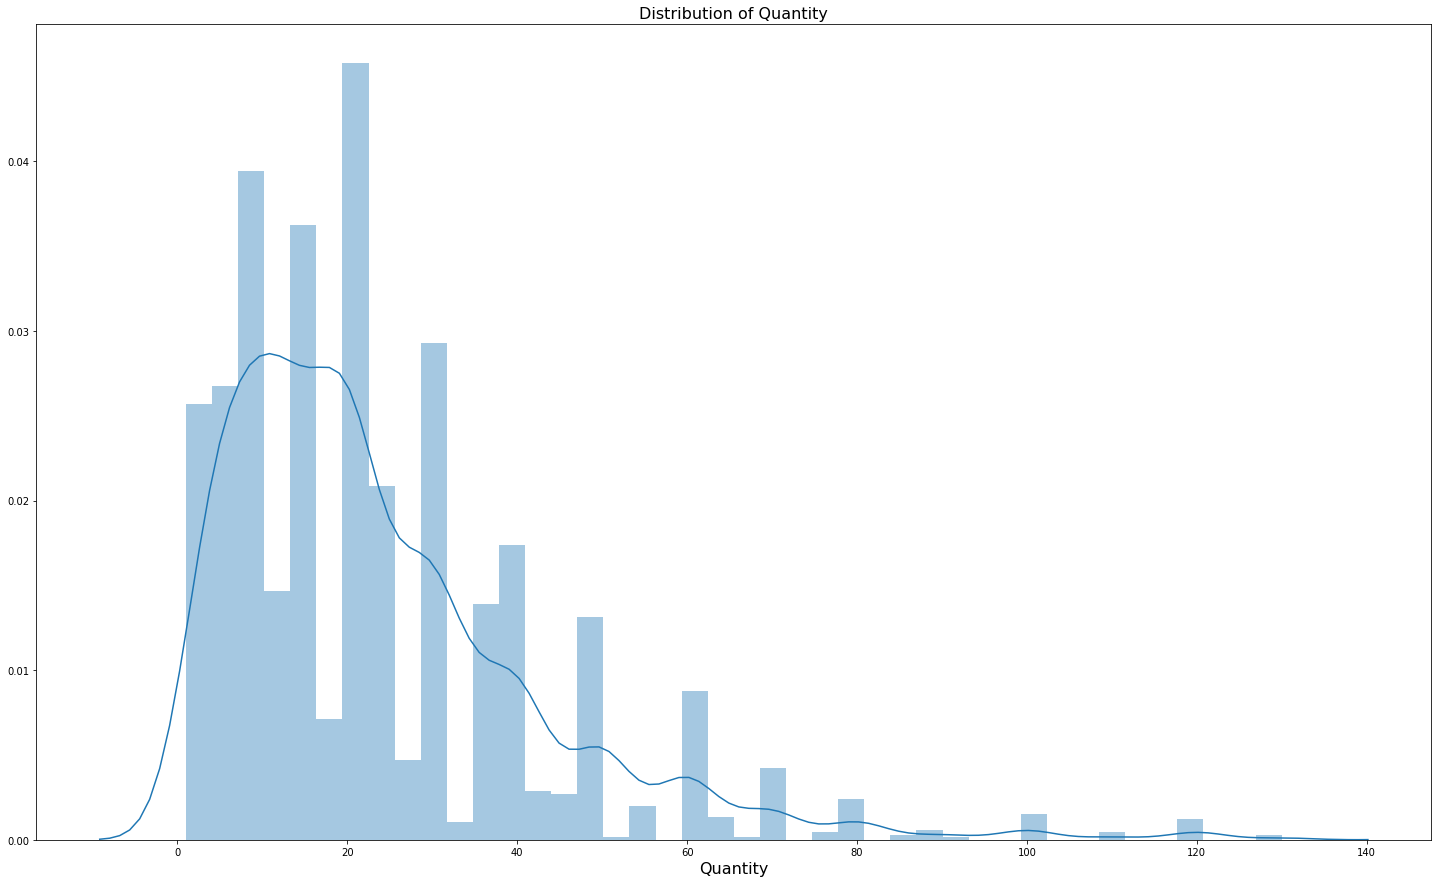

In [7]:

plt.figure(figsize=(25, 15))
sns.distplot(df_orders['Quantity'], hist='density')
plt.title('Distribution of Quantity', fontsize=16)
plt.xlabel('Quantity', fontsize=16)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Discount')

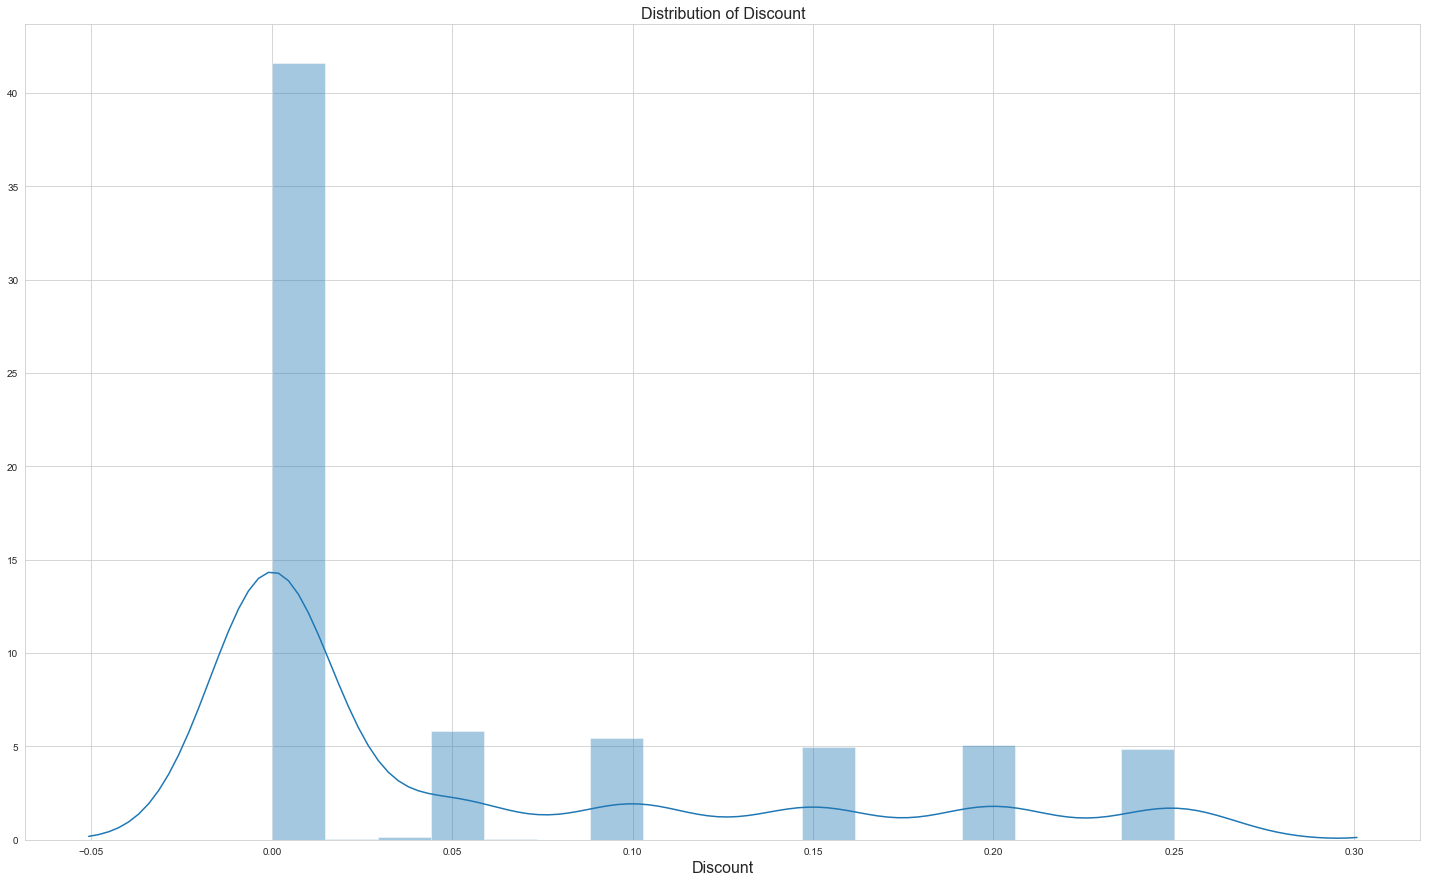

In [8]:
sns.set_style("whitegrid")

plt.figure(figsize=(25, 15))
sns.distplot(df_orders['Discount'], hist='density')
plt.title('Distribution of Discount', fontsize=16)
plt.xlabel('Discount', fontsize=16)

The **Dependent Variable - Quantity** is positively skewed with a minimum order quantity of 1 and the largest order was 130.  Meaning that most orders include only a few items.  This imaginary business would like to increase the quantity of items sold in each order placed.  Somebody had the idea that the level of discount offered is directly related to the quantity of items a customer orders.  Therefore our **Independent Variable-Discount** is shown above.  We can immediately see that most orders have no discount and the largest discount offered is 25%.  **Discount** is assumed to be assigned to a total order and not individual products.  Also, there is one discount between 0 and 5% that can be eliminated from our dataset making **Discount** an **ordinal variable/feature** that has a very near, but not quite, **uniform distribution** across the 5%, 10%, 15%, 20%, 25% increments.

**In order to select the most appropriate statistical test, a researcher should answer the following six questions.**<br>

1) How many variables will we be tracking?<br>
**2 variables, both are currently assumed to be independent our hypothesis test is interested in discovering a relationship between the IV - Discount and DV - Quantity** br  
2) At what level of measurement is the independent variable?<br>
**ordinal- the percentages are discrete yet in rank order**<br>
3) What is the level of measurement of the dependent variable?<br>
**continuous integers**
4) Are the observations independent or dependent?<br>
**We are given no information about how the discount level is chosen when a sale is made.  Therefore, it is assumed that these 2 features are independent**
5) Do the comparisons involve populations to populations, a sample to a population, or are two or more samples compared?<br> 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3105563/ read this when I have time
**I will be creating samples from 
6) Is the hypothesis being tested comparative or relationship?<br>


## 2 Experiment Design

### 2.1 Setting up control and experimental groups

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_** <br>

- The **control** group is comprised of orders that did not receive a discount<br>
- The **experimental** group is comprised of orders that did receive a discount<br>


In [9]:
# create control and experimental groups
# put items without the variable we are curious about into control group
control = df_orders[df_orders['Discount'] == 0]
ctrl = control['Quantity']

# put items with the variable we are curious about into experimental group
experimental = df_orders[df_orders['Discount'] != 0]
exp= experimental["Quantity"]

In [10]:
control.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [11]:
ctrl.head()

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

In [12]:
experimental.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


### 2.2 Checking Assumptions

#### 2.2.1 Normality


In order to perform a two-sample t-test, there are several assumptions that need to be met, the first of which is normality. We will assess this visually and also perform a normality test using the [normaltest function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) which combines measures of skew and kurtosis.

Control


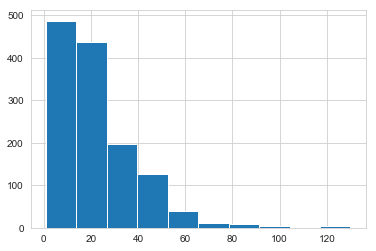

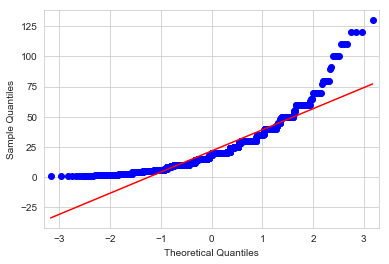

Experimental


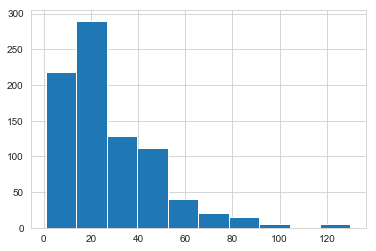

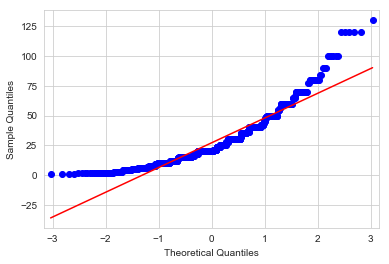

In [14]:
labels = ['Control','Experimental']
for ind, i in enumerate([ctrl, exp]):
    print (labels[ind])
    plt.hist(i)
    sm.qqplot(i, line='s')
    
    
    plt.show()


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


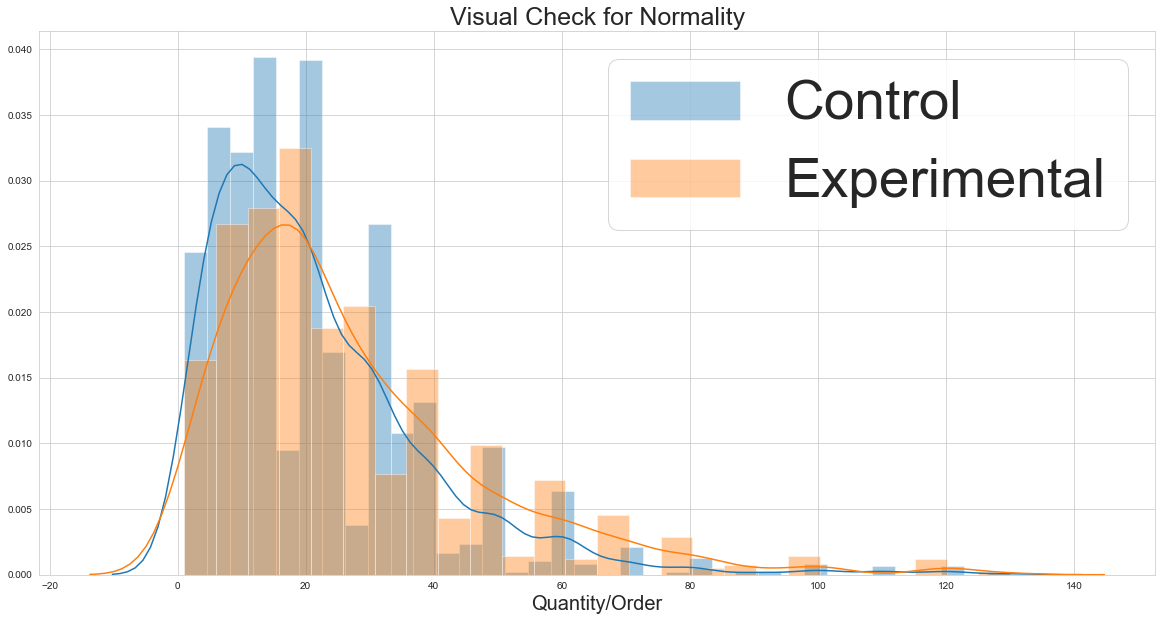

In [15]:
# visual check for normality
plt.figure(figsize=(20, 10))
sns.distplot(ctrl, label='Control')
sns.distplot(exp, label='Experimental',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=25)
plt.xlabel('Quantity/Order', fontsize=20)
plt.legend(fontsize=55);

We can see that both the control and test data sets are skewed positive through visual inspection we will now check that observation using scipy's normal test function.

In [16]:
# Use scipy's normal test function for both groups
import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(ctrl))
print('Normality of distribution: ', stat.normaltest(exp))

Normality of distribution:  NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of distribution:  NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


statistic = s^2 + k^2 = Skewness + Kurtosis  

In [17]:
stat.skewtest(ctrl) 

SkewtestResult(statistic=19.36939831677361, pvalue=1.3988262245980647e-83)

In [18]:
stat.kurtosistest(ctrl)

KurtosistestResult(statistic=13.015506651733459, pvalue=9.987763752128882e-39)

In [19]:
19.36939831677361**2 + 13.015506651733459**2 == 544.5770045551502

True

If the visual was not obvious enough, such a low p-value result from the scipy.stats.normaltest results should remove all doubt.  The resulting distribution is non-normal.  The results of both the experimental and control groups are positively skewed.  We can still use this sample thanks to the **Central Limit Theorem**. 

#### 2.2.2 Independence

The next assumption is independence both within and between groups. This assumption is satisfied because one order is not related to the other.  If the variables were dependent we would be given some information that the price of an item increases or decreases depending on supply/demand.  Since we are not told this we assume the variables are completely independent satisfying the independence assumption.

#### 2.2.3 Random

The last assumption is that samples are randomly chosen, meaning every observation has an equal chance of being selected. When we create the sampling distribution of sample mean, we will use numpy's [random.choice function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) to ensure a random sample is generated.

### 2.3 Creating a Sampling Distribution of Sample Mean

In [20]:
sample = ctrl+exp

In [21]:
len(ctrl)

1317

In [22]:
len(exp)

838

the mean value of discount applied treatement group or experimental group is about 5.4 units greater than the control group. We need to figure out if this is really significant by randomly selecting from an entire population where both groups are together. This will reduce the sensitivity to outliers and determine the probability that the larger value within the treatment group is actually just random luck.  We are hoping for a p-value of less than .05 so that we may reject the null hypothesis and take one step closer to recommending that the discounts do increase the amount of units sold.  What percentage of our tests will have a difference greater than 5.4?

In [23]:
#taking a look at the means
print("control " + str(ctrl.mean()))
print("experimental " + str(exp.mean()))    

control 21.715261958997722
experimental 27.10978520286396


In [24]:
original_diff = abs(ctrl.mean()-exp.mean())
original_diff

5.394523243866239

In [25]:
#check the amount of samples and use 1/2
i = int(np.round(len(df_orders)/2,0))
i 

1078

In [26]:
sample_a = df_orders["Quantity"].sample(1078)
sample_b = df_orders.drop(sample_a.index)["Quantity"]

In [27]:
sample_diff = np.mean(sample_a) - np.mean(sample_b)
sample_diff

-0.09913040931743566

In [28]:
%%time
my_diffs = []
for i in range(10000):
    sample_a = df_orders["Quantity"].sample(1078)
    sample_b = df_orders.drop(sample_a.index)["Quantity"]
    diff = np.mean(sample_a) - np.mean(sample_b)
    my_diffs.append(diff)

CPU times: user 12.4 s, sys: 28.5 ms, total: 12.4 s
Wall time: 12.4 s


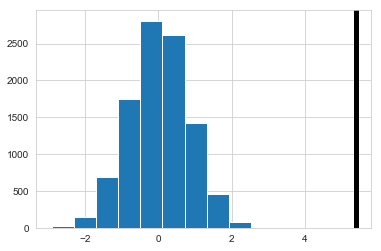

In [29]:
plt.hist(my_diffs)
plt.axvline(original_diff, color = 'k', linewidth = 5)
plt.show()


Visually I am convinced that the difference between quantity when a discount is provided vs the control (when there is no discount) is a statistically significant difference.  But I need an actual p-value

In [30]:
my_count = 0
for indv_diff in my_diffs:
    if indv_diff > original_diff:
        my_count += 1

In [31]:
my_count/len(my_diffs)

0.0

## 3 Two Sample t-test

### 3.1 Hypotheses, Type 1 & Type 2 errors


The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in...

$H_a:$ 

We set the significance level ($\alpha$) to 0.05 or 5%. In other words, this is the $\alpha$ value we are comfortable with for making a Type I error which we consider to be more serious than a Type II error. It is important to identify these errors early on so we can improve the test design. With this in mind, what we are trying to do is minimize the probability of committing a Type I error by maximizing the power (probability of making the correct decision when $H_a$ is true). This is one of the reasons why we chose a large sample size.

Type I error: reject 'discount amount has no effect' when it has no effect (i.e. keep offering discounts when it has no effect, resulting in lower revenue)

Type II error: accept 'discount amount has no effect' when it does have an effect (i.e. offer no discounts when it actually has an effect on quantity of product ordered, fail to capture potential revenue)



In [32]:
ttest_ind(exp.values, ctrl.values )

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

the very small p-value confirms that there is a statistically significant difference!

shouldn't I resample each group individually then run the "normalized" distributions through the t-test?

In [33]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

In [34]:
ctrl_sample = create_sample_distribution(ctrl)
exp_sample = create_sample_distribution(exp)

In [35]:
ttest_ind(exp.values, ctrl.values )

Ttest_indResult(statistic=6.4785631962949015, pvalue=1.1440924523215966e-10)

In [36]:
# Calculate Sample Variance
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)

In [37]:
# Calculate 2 sample t-statistc
def twosample_tstatistic(exp, ctrl):
    exp_mean, ctrl_mean = np.mean(exp), np.mean(ctrl)
    samp_var = sample_variance(exp, ctrl)
    n_e, n_c = len(exp), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(exp_sample, ctrl_sample)
t_stat

140.72818287986698

Given the above information we can calculate area under the curve to find p-value

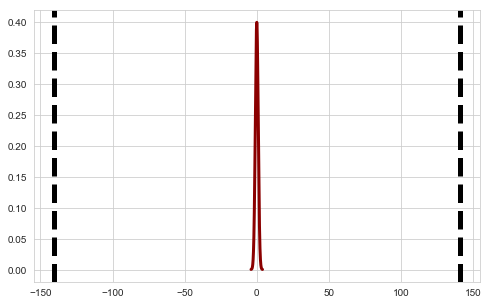

In [38]:
# Visualize p_value

def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred')

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5)

    plt.show()
    return None

n_control = len(ctrl_sample)
n_experimental = len(exp_sample)
visualize_t(t_stat, n_control, n_experimental)

### 3.2 Welch's t-test

In [39]:
# create control and experimental groups
# put items without the variable we are curious about into control group
control = df_orders[df_orders['Discount'] == 0]
ctrl = control['Quantity']

# put items with the variable we are curious about into experimental group
experimental = df_orders[df_orders['Discount'] != 0]
treatment= experimental["Quantity"]

In [40]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(ctrl, treatment)


 Welch's t-test= -6.2391 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1561.7678


### 3.3 Effect Size

## Cohen's $d$

Cohen’s D is one of the most common ways to measure effect size.  As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

Cohen’s d is similar to the unpaired t test t value. It relies on Standard Deviations instead of Standard Errors

The basic formula to calculate Cohen’s $d$ is:

> ** $d$ = effect size (difference of means) / pooled standard deviation **

The denominator is the **standardiser**, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean). 

In [41]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [42]:
ctrl_sample = np.array(ctrl_sample)
exp_sample = np.array(exp_sample)

The denominator of the equation is the standardiser and, it is important to select the most appropriate standardiser for a given dataset because it can have a big influence on Cohen’s d.

In [43]:
Cohen_d(ctrl_sample,exp_sample)

-6.296704805272617

large effect = 6.33

Parameters I am used to when dealing with Cohen's d

parameters 
small effect = 0 to .2 std 
med. effect = .2 to .8 std 
large effect > .8 std 

*Our Cohen's d value is 6.33; therefore we can categorize the difference as a small to medium effect size.*

### 3.4 One-way ANOVA

In [44]:

df_orders['Quantity'].groupby(df_orders['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [45]:

# wrap with C() to indicate categorical variable
results = ols('Quantity ~ C(Discount)', data=df_orders).fit()

In [46]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


In [47]:

mc = MultiComparison(df_orders['Quantity'], df_orders['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

## 4 Additional Hypothesis Tests

### 4.1 additional question 1

In [100]:
#get a list of all tables 
for row in c.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)


In [103]:
employee = pd.read_sql_query("SELECT * FROM Employee", conn)
category = pd.read_sql_query("SELECT * FROM Category", conn)
customer = pd.read_sql_query("SELECT * FROM Customer", conn)
shipper = pd.read_sql_query("SELECT * FROM Shipper", conn)
supplier = pd.read_sql_query("SELECT * FROM Supplier", conn)
#order = pd.read_sql_query("SELECT * FROM Order", conn)
product = pd.read_sql_query("SELECT * FROM Product", conn)
order_detail = pd.read_sql_query("SELECT * FROM OrderDetail", conn)
customer_customer_demo = pd.read_sql_query("SELECT * FROM CustomerCustomerDemo", conn)
customer_demographic = pd.read_sql_query("SELECT * FROM CustomerDemographic", conn)
region = pd.read_sql_query("SELECT * FROM Region", conn)
territory = pd.read_sql_query("SELECT * FROM Territory", conn)
employee_territory = pd.read_sql_query("SELECT * FROM EmployeeTerritory", conn)

In [122]:
print("Dimension of Employee Table is: {}".format(employee.shape))
print(100*" ")
print(employee.info())
print(100*" ")
print(employee.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(employee.describe())
print(100*" ")
print(employee.isnull().sum(axis=0))

Dimension of Employee Table is: (9, 18)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          8 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.3+ KB
None
                        

In [123]:
print("Dimension of category Table is: {}".format(category.shape))
print(100*" ")
print(category.info())
print(100*" ")
print(category.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(category.describe())
print(100*" ")
print(category.isnull().sum(axis=0))

Dimension of category Table is: (8, 3)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
Id              8 non-null int64
CategoryName    8 non-null object
Description     8 non-null object
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes
None
                                                                                                    
       CategoryName                          Description
count             8                                    8
unique            8                                    8
top     Confections  Desserts, candies, and sweet breads
freq              1                                    1
                                                                                                    
            Id
count  8.00000
mean   4.50000
std    2.44949
min    1.00000
25%    2.75000
50%    4.50000
75%    

In [124]:
print("Dimension of customer Table is: {}".format(customer.shape))
print(100*" ")
print(customer.info())
print(100*" ")
print(customer.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(customer.describe())
print(100*" ")
print(customer.isnull().sum(axis=0))

Dimension of customer Table is: (91, 11)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
Id              91 non-null object
CompanyName     91 non-null object
ContactName     91 non-null object
ContactTitle    91 non-null object
Address         91 non-null object
City            91 non-null object
Region          91 non-null object
PostalCode      90 non-null object
Country         91 non-null object
Phone           91 non-null object
Fax             69 non-null object
dtypes: object(11)
memory usage: 7.9+ KB
None
                                                                                                    
           Id                           CompanyName           ContactName  \
count      91                                    91                    91   
unique     91                                    91                  

In [125]:
print("Dimension of shipper Table is: {}".format(shipper.shape))
print(100*" ")
print(shipper.info())
print(100*" ")
print(shipper.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(shipper.describe())
print(100*" ")
print(shipper.isnull().sum(axis=0))

Dimension of shipper Table is: (3, 3)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
Id             3 non-null int64
CompanyName    3 non-null object
Phone          3 non-null object
dtypes: int64(1), object(2)
memory usage: 152.0+ bytes
None
                                                                                                    
           CompanyName           Phone
count                3               3
unique               3               3
top     Speedy Express  (503) 555-9831
freq                 1               1
                                                                                                    
        Id
count  3.0
mean   2.0
std    1.0
min    1.0
25%    1.5
50%    2.0
75%    2.5
max    3.0
                                                                                                    
Id    

In [126]:
print("Dimension of supplier Table is: {}".format(supplier.shape))
print(100*" ")
print(supplier.info())
print(100*" ")
print(supplier.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(supplier.describe())
print(100*" ")
print(supplier.isnull().sum(axis=0))

Dimension of supplier Table is: (29, 12)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
Id              29 non-null int64
CompanyName     29 non-null object
ContactName     29 non-null object
ContactTitle    29 non-null object
Address         29 non-null object
City            29 non-null object
Region          29 non-null object
PostalCode      29 non-null object
Country         29 non-null object
Phone           29 non-null object
Fax             13 non-null object
HomePage        5 non-null object
dtypes: int64(1), object(11)
memory usage: 2.8+ KB
None
                                                                                                    
                      CompanyName     ContactName          ContactTitle  \
count                          29              29                    29   
unique                        

In [127]:
print("Dimension of product Table is: {}".format(product.shape))
print(100*" ")
print(product.info())
print(100*" ")
print(product.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(product.describe())
print(100*" ")
print(product.isnull().sum(axis=0))

Dimension of product Table is: (77, 10)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB
None
                                                                                                    
         ProductName     QuantityPerUnit
count             77                  77
unique            77                  70
top     Alice Mutton  24 - 12 oz bottles
freq               1                   4
         

In [128]:
print("Dimension of order_detail Table is: {}".format(order_detail.shape))
print(100*" ")
print(order_detail.info())
print(100*" ")
print(order_detail.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(order_detail.describe())
print(100*" ")
print(order_detail.isnull().sum(axis=0))

Dimension of order_detail Table is: (2155, 6)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None
                                                                                                    
              Id
count       2155
unique      2155
top     10380/53
freq           1
                                                                                                    
            OrderId    ProductId    UnitPrice     Quantity     Discount
count   2155.000000  2155.000000  2155.000000  2155.000000  2155.000000
mean   10659.375870    40.793039    26.21852

In [129]:
print("Dimension of region Table is: {}".format(region.shape))
print(100*" ")
print(region.info())
print(100*" ")
print(region.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(region.describe())
print(100*" ")
print(region.isnull().sum(axis=0))

Dimension of region Table is: (4, 2)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
Id                   4 non-null int64
RegionDescription    4 non-null object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes
None
                                                                                                    
       RegionDescription
count                  4
unique                 4
top              Eastern
freq                   1
                                                                                                    
             Id
count  4.000000
mean   2.500000
std    1.290994
min    1.000000
25%    1.750000
50%    2.500000
75%    3.250000
max    4.000000
                                                                                                    
Id                   0
RegionDescription    0
dtype: 

In [130]:
print("Dimension of territory Table is: {}".format(territory.shape))
print(100*" ")
print(territory.info())
print(100*" ")
print(territory.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(territory.describe())
print(100*" ")
print(territory.isnull().sum(axis=0))

Dimension of territory Table is: (53, 3)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
Id                      53 non-null object
TerritoryDescription    53 non-null object
RegionId                53 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
                                                                                                    
           Id TerritoryDescription
count      53                   53
unique     53                   52
top     98004             New York
freq        1                    2
                                                                                                    
        RegionId
count  53.000000
mean    2.150943
std     1.081243
min     1.000000
25%     1.000000
50%     2.000000
75%     3.000000
max     4.000000
                                           

In [131]:
print("Dimension of employee_territory Table is: {}".format(employee_territory.shape))
print(100*" ")
print(employee_territory.info())
print(100*" ")
print(employee_territory.select_dtypes(exclude=['float64','int64']).describe())
print(100*" ")
print(employee_territory.describe())
print(100*" ")
print(employee_territory.isnull().sum(axis=0))

Dimension of employee_territory Table is: (49, 3)
                                                                                                    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
Id             49 non-null object
EmployeeId     49 non-null int64
TerritoryId    49 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ KB
None
                                                                                                    
             Id TerritoryId
count        49          49
unique       49          49
top     3/31406       44122
freq          1           1
                                                                                                    
       EmployeeId
count   49.000000
mean     5.510204
std      2.475904
min      1.000000
25%      3.000000
50%      6.000000
75%      7.000000
max      9.000000
                                                                                       

In [113]:
employee_territory.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [112]:
territory.TerritoryDescription.unique()

array(['Westboro', 'Bedford', 'Georgetow', 'Boston', 'Cambridge',
       'Braintree', 'Providence', 'Hollis', 'Portsmouth', 'Wilton',
       'Morristown', 'Edison', 'New York', 'Mellvile', 'Fairport',
       'Philadelphia', 'Neward', 'Rockville', 'Greensboro', 'Cary',
       'Columbia', 'Atlanta', 'Savannah', 'Orlando', 'Tampa',
       'Louisville', 'Beachwood', 'Findlay', 'Southfield', 'Troy',
       'Bloomfield Hills', 'Racine', 'Roseville', 'Minneapolis',
       'Hoffman Estates', 'Chicago', 'Bentonville', 'Dallas', 'Austin',
       'Denver', 'Colorado Springs', 'Phoenix', 'Scottsdale',
       'Santa Monica', 'Menlo Park', 'San Francisco', 'Campbell',
       'Santa Clara', 'Santa Cruz', 'Bellevue', 'Redmond', 'Seattle'],
      dtype=object)

In [108]:
territory.RegionId.unique()

array([1, 3, 4, 2])

In [110]:
region

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [94]:
# new data frame with split value columns 
new = cust["ContactName"].str.split(" ", n = 1, expand = True) 
  
# making seperate first name column from new data frame 
cust["FirstName"]= new[0] 
  
# making seperate last name column from new data frame 
cust["LastName"]= new[1] 
  
# df display 
cust

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,FirstName,LastName
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,Maria,Anders
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,Ana,Trujillo
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,Antonio,Moreno
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,Thomas,Hardy
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,Christina,Berglund
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,Hanna,Moos
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,Frédérique,Citeaux
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,Martín,Sommer
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,Laurence,Lebihan
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,Elizabeth,Lincoln


In [48]:
df_orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


#### 4.1.2 Retrieve data from database

In [49]:
control = df_orders[df_orders['Discount'] == 0].copy()
control["Total"]= control['UnitPrice']*control["Quantity"]


experimental = df_orders[df_orders['Discount'] != 0].copy()
experimental["Total"]= experimental["Quantity"]*experimental["UnitPrice"]*(1-experimental["Discount"])

In [51]:
experimental.sample(20)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Total
1727,10912/29,10912,29,123.79,60,0.25,5570.55
211,10327/30,10327,30,20.70,35,0.20,579.60
1352,10760/43,10760,43,46.00,30,0.25,1035.00
2008,11025/13,11025,13,6.00,20,0.10,108.00
1064,10653/16,10653,16,17.45,30,0.10,471.15
858,10569/31,10569,31,12.50,35,0.20,350.00
1337,10755/69,10755,69,36.00,25,0.25,675.00
1474,10812/72,10812,72,34.80,40,0.10,1252.80
334,10373/58,10373,58,10.60,80,0.20,678.40
1447,10801/29,10801,29,123.79,20,0.25,1856.85


In [58]:
experimental.groupby('OrderId', axis=1, squeeze=True)

In [59]:
experimental

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Total
6,10250/51,10250,51,42.40,35,0.15,1261.4000
7,10250/65,10250,65,16.80,15,0.15,214.2000
8,10251/22,10251,22,16.80,6,0.05,95.7600
9,10251/57,10251,57,15.60,15,0.05,222.3000
11,10252/20,10252,20,64.80,40,0.05,2462.4000
12,10252/33,10252,33,2.00,25,0.05,47.5000
17,10254/24,10254,24,3.60,15,0.15,45.9000
18,10254/55,10254,55,19.20,21,0.15,342.7200
29,10258/2,10258,2,15.20,50,0.20,608.0000
30,10258/5,10258,5,17.00,65,0.20,884.0000


### 4.2 additional question 2


### 4.3 additional question 3


## 5 Conclusions

use bullet points and restate either the null or alternative hypothesis that we found to be true in each experiment respectably.  

### 5.1 Next Steps- Building off this project

Use bullet points to list off at least 2 other tests we could run if we have more time later on.